# Analysis on the simulation of real-time driving request to nearest Stroke cares in Vietnam

The project is a part of the World Bank's Disruptive Technology for Public Assets Governance (DT4PAG) supporting the Government of Vietnam. This work is done by Tuan Phan, Parvathy Krisnan, and Kai Kaiser from the World Bank.

For this blog, we will showcase the power of cloud base technology to help officials in the Vietnam's public sectors to cope with the new technology age. We use Google's Colab environment for data analytics and Google Drive as storage.

In [ ]:
#@title
!pip install geopandas pandas 2>&1 >/dev/null
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#@title
from google.colab import drive
# To use this collab, please take note on how to mount the data drive
# 1. Add shortcut of the Tuan_Analysis_Vietnam_Stroke_Flood folder to your Main Drive
# 2. Done :D. 
# Remember, you have to add the shortcut to your Main Drive folder
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#@title
root_dir = './drive/MyDrive/Tuan_Analysis_Vietnam_Stroke/'
import sys
sys.path.append(root_dir)

# I. Introduction

## 1. Background

## 2. Aims of the simulation

The study will focus on these points to understand how choosing a cut-off point will affect the overall project's stability, its scalibility, and the potential patients' experience:
* Best cut-off based on haversine distance and its effect on actual driving time.
* The effect of traffic hours on the cut-off.
* The effect of provincial positions on the cut-off.

# II. Methodology

## 1. Technical Details

### Algorithm

Explain the algorithm here

### Function list

This one helps to randomize a GPS point based on a province's boundary

In [ ]:
def random_gps(bounds: Polygon):
    """
    Modular function to automatically random a new gps point
    based on the polygon boundary
    :param bounds: the Polygon object passed from the geojson df
    :return: new GPS point
    """
    inside_poly = False
    min_lon, min_lat, max_lon, max_lat = bounds.bounds
    # I understand this randomization process is very inefficient, but ...
    # deadline is more important,
    # so I will leave this to whoever is better to solve it for me
    while not inside_poly:
        new_lon = round(np.random.uniform(min_lon, max_lon), 5)
        new_lat = round(np.random.uniform(min_lat, max_lat), 5)
        new_gps = Point(new_lon, new_lat)
        if bounds.contains(new_gps):
            inside_poly = True
            return new_lon, new_lat
    return False

This function helps to form the request, and send it, to Mapbox's API for one source coordinate pair and a list of destination's coordinates

In [ ]:
def travel_time_req(source_lon, source_lat, to_list):
    """
    Request Mapbox API to calculate drive-time from a source point to
    list of facilities
    :param source_lon: source's longitude
    :param source_lat: source's latitude
    :param to_list: list of coordinates from different facilities
    :return: a list driving-time with index corresponding to
                the order of facilities in the original to_list
    """
    # the coordinate pair come in the form of: (longitude. latitude)
    coordinate_str = str(source_lon) + ',' + str(source_lat)
    for destination in to_list:
        coordinate_str += ';' + str(destination[0]) + ',' + str(destination[1])
    token = """pk.eyJ1IjoicGFydmF0aHlrcmlzaG5hbmsiLCJhIjoiY2tybGFoMTZwMGJjdDJybnYyemwxY3QxMSJ9.FXaVYsMF3HIzw7ZQFQPhSw"""
    # Mapbox API is used with max of 10 coordinates per request
    # maximum is 30 request per minute
    # coordinate request is in the form of : /lon1, lat1;lon2, lat2;.../
    # one can use the parameter {sources} to point which coordinate pair is
    # the destination to reduce request time
    # same can be said about {destination}
    request_url = """https://api.mapbox.com/directions-matrix/v1/mapbox/driving-traffic/"""
    request_params = """?annotations=duration&sources=0&access_token="""
    request_mapbox_driving = request_url + coordinate_str + request_params + token
    try:
        request_pack = json.loads(requests.get(request_mapbox_driving).content)
        if 'messsage' in request_pack.keys():
            if request_pack['durations'] == "Too Many Requests":
                print('Use too many at ' + str(datetime.today()))
                return False
        duration_minutes = request_pack['durations'][0][1:]
        return duration_minutes
    except Exception as e:
        print(e)
        # I did a blind try-except
        # since I dont know which error might come from the MapBox API
        # either they dont have the calculation
        # or the token has reached its minutely limit
        return False

The function below provide the 45 facilities with the closest haversine distances from a source point. It is sorted ascendingly

In [ ]:
def return_closest_45(source_lon, source_lat, facs_df):
    """
    Return the closest 45 facilities in haversine distance.
    The returned df is sort ascendingly
    :param source_lon: longitude of the source GPS
    :param source_lat: latitude of the source GPS
    :param facs_df: facilities df
    :return:
    """
    res_df = deepcopy(facs_df)
    harv_dist = np.zeros(res_df.shape[0], dtype=float)
    for i in range(len(harv_dist)):
        dest_lon = res_df['Lon'].iloc[i]
        dest_lat = res_df['Lat'].iloc[i]
        harv_dist[i] = haversine_vectorize(source_lon, source_lat, dest_lon,
                                           dest_lat)
    res_df['Harversine_Dist'] = harv_dist
    res_df.sort_values('Harversine_Dist', inplace=True)
    res_df.reset_index(inplace=True, drop=True)
    return res_df.iloc[:45, :]

The core function helps to merge the above functions into one big platform to perform the simulation for each province. Each time it is called, the core function will break the closest 45 facilities list into 5 lists of 9 facilities each and call the request function to Mapbox's API. Then, it would format and register the result into the database/csv file.

In [ ]:
def simulation_core(prov_name, prov_df: pd.DataFrame, facs_df: pd.DataFrame):
    """
    Core part of the simulation. It requests the driving-time API
     and calculate result. This would later become the core for the main API
    :param prov_name: code name of the province
    :param prov_df: province df
    :param facs_df: facilities df
    :return:
        - final_drive_res: str of the list of the driving time from the source
                            to the 45 closest facilities
        - final_request_time: str of the list of the request time from
                                MapBox API
        - str of the coordinates for the source GPS
        - harv_dist_str: str of the list of the harvesine distances
                        from the source to 45 closest facilities
    """
    # take out the rows of the interested province
    prov_geometry = prov_df.where(prov_df['GID_1'] == prov_name)
    prov_geometry.dropna(inplace=True)
    # randomly choose one of the polygon
    # from the rows of polygons forming the province
    geo_choice = np.random.randint(0, prov_geometry.shape[0])
    # create a randomized gps point from the boundary
    gps_lon, gps_lat = random_gps(prov_geometry["geometry"].iloc[geo_choice])

    # data preparation for the facilities list
    facs_df_45 = return_closest_45(gps_lon, gps_lat, facs_df)
    harv_dist_list = facs_df_45['Harversine_Dist'].to_numpy().tolist()
    facs_list = facs_df_45[['Lon', 'Lat']].to_numpy().tolist()

    final_drive_res = ''
    final_request_time = ''

    for i in range(5):
        start_idx = i * 9
        end_idx = (i + 1) * 9
        # the queried_res come in the form of list of drive time in seconds
        # with corresponding index with the facilities
        start_time = datetime.now()
        queried_res = travel_time_req(gps_lon, gps_lat,
                                      facs_list[start_idx: end_idx])
        # here is to capture the case of failed connection and limited access
        # from Mapbox API
        if not queried_res:
            queried_res = []
        end_time = datetime.now()
        cost = round((end_time - start_time).microseconds / 1000, 2)
        # transform the result list into str for db log
        final_drive_res += ','.join(str(x) for x in queried_res)
        final_request_time = final_request_time + ',' + str(cost)
    # remove unnecessary comma and data prep before returning result
    final_drive_res = final_drive_res.strip()
    final_request_time = final_request_time.strip()
    harv_dist_str = ','.join(str(x) for x in harv_dist_list).strip()
    return final_drive_res, final_request_time[1:], str(gps_lon) + ',' + str(
        gps_lat), harv_dist_str

This is the main body of the program. It mostly helps to perform collateral tasks such as rest the simulation core to conform to one minute limitation set out by Mapbox or coordinate which province to be called for simulation, etc.

In [ ]:
def main():
    """
    Main simulation function
    :return: None
    """
    file_name = './Data/gadm_vietnam.geojson'
    province_bounds = gpd.read_file(file_name, driver='GeoJSON')
    province_bounds = deepcopy(province_bounds[['GID_1', 'NAME_1', 'geometry']])
    province_list = list(set(province_bounds['GID_1'].to_numpy().tolist()))
    stroke_facs = pd.read_csv('./Data/stroke_facs_latest.csv')
    stroke_facs = deepcopy(stroke_facs[['Name_English', 'longitude', 'latitude',
                                        'pro_name_e', 'dist_name_e']])
    stroke_facs.columns = ['Facility_Name', 'Lon', 'Lat', 'Province',
                           'District']
    number_of_province = 63
    number_of_simulation = 5000
    # the number is 5000 not 30000 because for each minute,
    # I can send 30 requests with 9 stroke centres each request
    # thus, for each minute, I can simulate 6 GPS points at the same time
    # roughly, since I will not try to do multithreading,
    # it will all be sequential request
    simulate_list = province_list + np.random.choice(province_list, 57).tolist()
    np.random.shuffle(simulate_list)
    for _ in tqdm(range(number_of_simulation)):
        # for the distribution of time request across all 63 provinces
        # in each hour, I will do a subset of 60 provinces from the list of 63
        start_time = datetime.now()
        for idx in range(6):
            # if the list run out of candidate to use, recreate the list
            if len(simulate_list) == 0:
                simulate_list = province_list + np.random.choice(province_list,
                                                                 57).tolist()
                np.random.shuffle(simulate_list)

            start_each = datetime.today()
            # main simulation
            first_prov = simulate_list.pop()
            final_drive_res, final_request_time, gps_str, harv_dist_str = simulation_core(
                first_prov,
                province_bounds, stroke_facs)
            end_first = datetime.now()
            cost_first = round((start_each - end_first).microseconds / 1000, 2)
            record_result((start_each, gps_str, first_prov,
                           final_drive_res, harv_dist_str, final_request_time,
                           cost_first))

        end_time = datetime.now()
        # cost time is used to control if we have reached the
        # maximum request per minute set out by MapBox or not
        cost_time = (end_time - start_time).total_seconds()
        if cost_time < 60:
            time.sleep(60 - cost_time)
    return

## 2. Final results

# III. Analysis

## Prep

In [ ]:
import pandas as pd
res_file = root_dir + 'Data/simulation_112121.csv'
res_df = pd.read_csv(res_file, header=None)
res_df.columns = ['time_req', 'coords', 'prov_code', 'drive_time', 'harv_dist',
                  'resp_time', 'total_time']

In [ ]:
import geopandas as gpd
vn_prov = gpd.read_file(root_dir + '/Data/gadm_vietnam.geojson')
vn_prov

,GID_0,NAME_0,GID_1,NAME_1,VARNAME_1,NL_NAME_1,TYPE_1,ENGTYPE_1,CC_1,HASC_1,geometry
0,VNM,Vietnam,VNM.1_1,An Giang,An Giang,None,Tỉnh,Province,None,VN.AG,"POLYGON ((105.37450 10.24604, 105.33623 10.234..."
1,VNM,Vietnam,VNM.2_1,Bạc Liêu,Bac Lieu,None,Tỉnh,Province,None,VN.BL,"POLYGON ((105.41638 9.01717, 105.41731 9.02926..."
2,VNM,Vietnam,VNM.3_1,Bắc Giang,Bac Giang,None,Tỉnh,Province,None,VN.BG,"POLYGON ((105.96444 21.23003, 105.96074 21.230..."
3,VNM,Vietnam,VNM.4_1,Bắc Kạn,Bac Kan,None,Tỉnh,Province,None,VN.BK,"POLYGON ((105.59045 22.00770, 105.58698 22.003..."
4,VNM,Vietnam,VNM.5_1,Bắc Ninh,Bac Ninh,None,Tỉnh,Province,None,VN.BN,"POLYGON ((106.02851 20.99314, 106.02468 20.996..."
...,...,...,...,...,...,...,...,...,...,...,...
1249,VNM,Vietnam,VNM.59_1,Trà Vinh,Tra Vinh,None,Tỉnh,Province,None,VN.TV,"POLYGON ((106.50567 9.56151, 106.48796 9.55054..."
1250,VNM,Vietnam,VNM.60_1,Tuyên Quang,Tuyen Quang,None,Tỉnh,Province,None,VN.TQ,"POLYGON ((105.45863 21.51856, 105.45708 21.517..."
1251,VNM,Vietnam,VNM.61_1,Vĩnh Long,Vinh Long,None,Tỉnh,Province,None,VN.VL,"POLYGON ((106.11272 9.93837, 106.10242 9.94895..."
1252,VNM,Vietnam,VNM.62_1,Vĩnh Phúc,Vinh Phuc,None,Tỉnh,Province,None,VN.VC,"POLYGON ((105.71557 21.22469, 105.71361 21.222..."


In [ ]:
import numpy as np
from tqdm import tqdm
from copy import deepcopy

analysis_df = deepcopy(res_df[['prov_code']])
gid = vn_prov['GID_1'].tolist()
var_name = vn_prov['VARNAME_1'].tolist()
combination = np.array(list(set(zip(gid, var_name))))
urban_prov = ['Ha Noi', 'Ho Chi Minh', 'Da Nang']
row_count = res_df.shape[0]

prov_name_list = []
urban_list = []
for i in tqdm(range(row_count)):
    prov_code = analysis_df.prov_code[i]
    prov_name = combination[np.where(combination==prov_code)[0][0]][1]
    prov_name_list.append(prov_name)
    if prov_name in urban_prov:
        urban_list.append(True)
    else:
        urban_list.append(False)

analysis_df['Province'] = prov_name_list
analysis_df['Urban'] = urban_list

100%|██████████| 30120/30120 [00:00<00:00, 50537.16it/s]


In [ ]:
import numpy as np
from copy import deepcopy
from tqdm import tqdm
import math
from datetime import datetime

template_array = np.ones(row_count) * np.nan
# add fastest drive time, and the position
analysis_df['fastest_drive'] = deepcopy(template_array)
analysis_df['closest_facs'] = deepcopy(template_array)
analysis_df['failed'] = [True for x in range(row_count)]
analysis_df['rush_hour'] = [False for x in range(row_count)]
analysis_df['top_9'] = deepcopy(template_array)
analysis_df['diff_top_9'] = deepcopy(template_array)
analysis_df['top_18'] = deepcopy(template_array)
analysis_df['diff_top_18'] = deepcopy(template_array)
analysis_df['top_27'] = deepcopy(template_array)
analysis_df['diff_top_27'] = deepcopy(template_array)
for i in tqdm(range(row_count)):
    time_req = datetime.strptime(res_df['time_req'][i],
                                 '%Y-%m-%d %H:%M:%S')
    if 7 <= time_req.hour <= 9 or 17 <= time_req.hour <= 19:
        analysis_df['rush_hour'][i] = True
    all_time = res_df['drive_time'][i].split(',')
    time_array = []
    for j in all_time:
        try:
            time_array.append(round(float(j) / 3600, 2))
        except:
            continue
    if len(time_array) == 0:
        continue

    min_time = min(time_array)
    if not math.isnan(min_time):
        analysis_df['failed'][i] = False
        analysis_df['fastest_drive'][i] = min_time
        analysis_df['closest_facs'][i] = np.argmin(time_array)
        # time_array = sorted(time_array)
        analysis_df['top_9'][i] = min(time_array[:8])
        analysis_df['diff_top_9'][i] = min_time - min(time_array[:8])
        analysis_df['top_18'][i] = min(time_array[9:17])
        analysis_df['diff_top_18'][i] = min_time - min(time_array[:17])
        analysis_df['top_27'][i] = min(time_array[18:26])
        analysis_df['diff_top_27'][i] = min_time - min(time_array[:26])

analysis_df = analysis_df.dropna()
analysis_df.head(10)

100%|██████████| 30120/30120 [00:25<00:00, 1203.10it/s]


,prov_code,Province,Urban,fastest_drive,closest_facs,failed,rush_hour,top_9,diff_top_9,top_18,diff_top_18,top_27,diff_top_27
0,VNM.63_1,Yen Bai,False,0.99,0.0,False,False,0.99,0.0,3.22,0.0,3.66,0.0
1,VNM.2_1,Bac Lieu,False,2.07,1.0,False,False,2.07,0.0,3.67,0.0,5.96,0.0
2,VNM.24_1,Hau Giang,False,1.01,0.0,False,False,1.01,0.0,1.76,0.0,4.04,0.0
3,VNM.1_1,An Giang,False,2.68,0.0,False,False,2.68,0.0,5.54,0.0,6.56,0.0
4,VNM.5_1,Bac Ninh,False,0.81,0.0,False,False,0.81,0.0,1.26,0.0,1.70,0.0
5,VNM.44_1,Phu Tho,False,2.20,0.0,False,False,2.20,0.0,3.33,0.0,3.94,0.0
6,VNM.63_1,Yen Bai,False,1.99,0.0,False,False,1.99,0.0,4.22,0.0,4.67,0.0
7,VNM.30_1,Hoa Binh,False,1.11,0.0,False,False,1.11,0.0,2.49,0.0,3.44,0.0
8,VNM.19_1,Da Nang,True,1.10,0.0,False,False,1.10,0.0,8.24,0.0,15.15,0.0
9,VNM.49_1,Quang Ninh,False,9.04,0.0,False,False,9.04,0.0,10.70,0.0,10.88,0.0


## 1. Best cut-off based on haversine distance and its effect on actual driving time.


In [ ]:
import matplotlib.pyplot as plt
closest_facs = analysis_df['closest_facs'].tolist()
list_pos = list(set(closest_facs))
pos_count = []
pos_perc = []
cum_perc_list = []
cum_perc = np.float(0)

for pos in list_pos:
    curr_count = closest_facs.count(pos)
    pos_count.append(curr_count)
    curr_perc = curr_count/len(closest_facs)
    pos_perc.append(curr_perc)
    cum_perc += curr_perc
    cum_perc_list.append(cum_perc)

cut_off_df = pd.DataFrame({'facility index': list_pos,
                           'count': pos_count,
                           'percentage': pos_perc,
                           'cumulative percentage': cum_perc_list})
cut_off_df

,facility index,count,percentage,cumulative percentage
0,0.0,23231,0.783984,0.783984
1,1.0,3660,0.123515,0.907499
2,2.0,1495,0.050452,0.957951
3,3.0,458,0.015456,0.973407
4,4.0,356,0.012014,0.985421
5,5.0,176,0.005940,0.991361
6,6.0,169,0.005703,0.997064
7,7.0,64,0.002160,0.999224
8,8.0,3,0.000101,0.999325
9,9.0,5,0.000169,0.999494


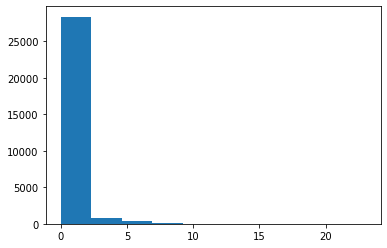

In [ ]:
n, bins, patches = plt.hist(closest_facs)
plt.show()

From the histogram, we need see the right tail of the distribution to see which cases are affected by the cut-off the most

In [ ]:
tail_res = analysis_df.where(analysis_df['closest_facs'] >= 10).dropna()
tail_res.sort_values(['closest_facs'], inplace=True, ascending=False)
tail_res.reset_index(drop=True, inplace=True)
tail_res

,prov_code,Province,Urban,fastest_drive,closest_facs,failed,rush_hour,top_9,diff_top_9,top_18,diff_top_18,top_27,diff_top_27
0,VNM.17_1,Dong Nai,0.0,0.65,23.0,0.0,0.0,1.11,-0.46,1.55,-0.46,0.65,0.0
1,VNM.58_1,Tien Giang,0.0,1.25,21.0,0.0,0.0,1.71,-0.46,1.75,-0.46,1.25,0.0
2,VNM.58_1,Tien Giang,0.0,1.33,20.0,0.0,0.0,1.79,-0.46,1.87,-0.46,1.33,0.0
3,VNM.58_1,Tien Giang,0.0,1.32,20.0,0.0,0.0,1.51,-0.19,1.58,-0.19,1.32,0.0
4,VNM.58_1,Tien Giang,0.0,1.32,20.0,0.0,0.0,1.51,-0.19,1.58,-0.19,1.32,0.0
5,VNM.58_1,Tien Giang,0.0,1.32,19.0,0.0,0.0,1.57,-0.25,1.65,-0.25,1.32,0.0
6,VNM.58_1,Tien Giang,0.0,1.29,19.0,0.0,1.0,1.52,-0.23,1.61,-0.23,1.29,0.0
7,VNM.58_1,Tien Giang,0.0,1.23,19.0,0.0,0.0,1.40,-0.17,1.47,-0.17,1.23,0.0
8,VNM.41_1,Nghe An,0.0,7.56,15.0,0.0,1.0,7.60,-0.04,7.56,0.00,8.56,0.0
9,VNM.5_1,Bac Ninh,0.0,0.73,13.0,0.0,0.0,0.75,-0.02,0.73,0.00,1.44,0.0


## 2. The effect of traffic hours on the cut-off.


### Normal hours' tests

In [ ]:
non_traffic_hour = analysis_df.where(analysis_df['rush_hour'] == False).dropna()['closest_facs'].tolist()
list_pos = list(set(non_traffic_hour))
pos_count = []
pos_perc = []
cum_perc_list = []
cum_perc = np.float(0)
for pos in list_pos:
    curr_count = non_traffic_hour.count(pos)
    pos_count.append(curr_count)
    curr_perc = curr_count/len(non_traffic_hour)
    pos_perc.append(curr_perc)
    cum_perc += curr_perc
    cum_perc_list.append(cum_perc)

cut_off_df = pd.DataFrame({'facs_pos': list_pos,
                           'count': pos_count,
                           'perc': pos_perc,
                           'cumulative': cum_perc_list})
cut_off_df

,facs_pos,count,perc,cumulative
0,1.0,17345,0.781025,0.781025
1,2.0,2719,0.122433,0.903458
2,3.0,1170,0.052684,0.956142
3,4.0,362,0.016300,0.972442
4,5.0,286,0.012878,0.985321
5,6.0,134,0.006034,0.991354
6,7.0,120,0.005403,0.996758
7,8.0,54,0.002432,0.999189
8,9.0,3,0.000135,0.999325
9,10.0,4,0.000180,0.999505


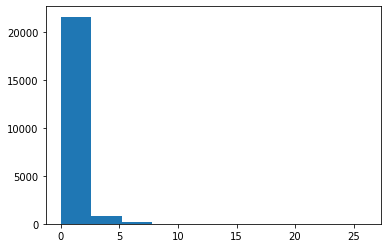

In [ ]:
n, bins, patches = plt.hist(non_traffic_hour)
plt.show()

### Rush hours' tests

We need to see if the normal level of cut-off would work as intended on rush hour, compared to the normal hour.

In [ ]:
traffic_df = analysis_df.where(analysis_df['rush_hour'] == True).dropna()
traffic_hour_list = traffic_df['closest_facs'].tolist()
list_pos = list(set(traffic_hour_list))
pos_count = []
pos_perc = []
cum_perc_list = []
cum_perc = np.float(0)
for pos in list_pos:
    curr_count = traffic_hour_list.count(pos)
    pos_count.append(curr_count)
    curr_perc = curr_count/len(traffic_hour_list)
    pos_perc.append(curr_perc)
    cum_perc += curr_perc
    cum_perc_list.append(cum_perc)

cut_off_df = pd.DataFrame({'facs_pos': list_pos,
                           'count': pos_count,
                           'perc': pos_perc,
                           'cumulative': cum_perc_list})

cut_off_df

,facs_pos,count,perc,cumulative
0,0.0,5886,0.792834,0.792834
1,1.0,941,0.126751,0.919585
2,2.0,325,0.043777,0.963362
3,3.0,96,0.012931,0.976293
4,4.0,70,0.009429,0.985722
5,5.0,42,0.005657,0.991379
6,6.0,49,0.006600,0.997980
7,7.0,10,0.001347,0.999327
8,9.0,1,0.000135,0.999461
9,10.0,1,0.000135,0.999596


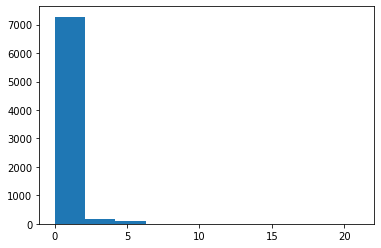

In [ ]:
n, bins, patches = plt.hist(traffic_hour_list)
plt.show()

It seems that a cut-off of 9 facilities provide decent result with minimal cost to the project as it only cost one request to provide 9 driving time results.

## 3. The effect of provincial positions on the cut-off.


We divide the df into two groups: Big cities/province (Hanoi, SG, Da Nang) and normal ones.

We would perform analysis to see if big cities have problem in finding a good cut-off in rush hour or not and if the rush-hour affect the normal provinces as well.

### Special Provinces/Cities

In [ ]:
urban_prov = ['Ha Noi', 'Ho Chi Minh', 'Da Nang']
urban_df = analysis_df.where(analysis_df['Urban'] == True).dropna().reset_index(drop=True)

In [ ]:
traffic_hour_list = urban_df['closest_facs'].tolist()
list_pos = list(set(traffic_hour_list))
pos_count = []
pos_perc = []
cum_perc_list = []
cum_perc = np.float(0)
for pos in list_pos:
    curr_count = traffic_hour_list.count(pos)
    pos_count.append(curr_count)
    curr_perc = curr_count/len(traffic_hour_list)
    pos_perc.append(curr_perc)
    cum_perc += curr_perc
    cum_perc_list.append(cum_perc)

cut_off_df = pd.DataFrame({'facility index': list_pos,
                           'count': pos_count,
                           'percentage': pos_perc,
                           'cumulative percentage': cum_perc_list})

cut_off_df

,facility index,count,percentage,cumulative percentage
0,0.0,1110,0.756131,0.756131
1,1.0,227,0.154632,0.910763
2,2.0,97,0.066076,0.976839
3,3.0,13,0.008856,0.985695
4,4.0,8,0.005450,0.991144
5,5.0,7,0.004768,0.995913
6,6.0,5,0.003406,0.999319
7,11.0,1,0.000681,1.000000


### Normal Provinces

We extract the normal provinces to evaluate the effectiveness of choosing a cut-off point for potential patients in normal provinces

In [ ]:
non_urban_df = analysis_df.where(analysis_df['Urban'] == False).dropna().reset_index(drop=True)

In [ ]:
traffic_hour = non_urban_df['closest_facs'].tolist()
list_pos = list(set(traffic_hour))
pos_count = []
pos_perc = []
cum_perc_list = []
cum_perc = np.float(0)
for pos in list_pos:
    curr_count = traffic_hour.count(pos)
    pos_count.append(curr_count)
    curr_perc = curr_count/len(traffic_hour)
    pos_perc.append(curr_perc)
    cum_perc += curr_perc
    cum_perc_list.append(cum_perc)

cut_off_df = pd.DataFrame({'facility index': list_pos,
                           'count': pos_count,
                           'percentage': pos_perc,
                           'cumulative percentage': cum_perc_list})
cut_off_df

,facility index,count,percentage,cumulative percentage
0,0.0,22121,0.785435,0.785435
1,1.0,3433,0.121893,0.907329
2,2.0,1398,0.049638,0.956966
3,3.0,445,0.015800,0.972767
4,4.0,348,0.012356,0.985123
5,5.0,169,0.006001,0.991123
6,6.0,164,0.005823,0.996946
7,7.0,64,0.002272,0.999219
8,8.0,3,0.000107,0.999325
9,9.0,5,0.000178,0.999503


It can be seen that, in rush hour, the situation in normal provinces are worst than that of big cities/provinces. They have longer right tail

In [ ]:
non_traffic_hour = non_urban_df.where(non_urban_df['rush_hour'] == False).dropna()['closest_facs'].tolist()
list_pos = list(set(non_traffic_hour))
pos_count = []
pos_perc = []
cum_perc_list = []
cum_perc = np.float(0)
for pos in list_pos:
    curr_count = non_traffic_hour.count(pos)
    pos_count.append(curr_count)
    curr_perc = curr_count/len(non_traffic_hour)
    pos_perc.append(curr_perc)
    cum_perc += curr_perc
    cum_perc_list.append(cum_perc)

cut_off_df = pd.DataFrame({'facs_pos': list_pos,
                           'count': pos_count,
                           'perc': pos_perc,
                           'cumulative': cum_perc_list})
cut_off_df

,facs_pos,count,perc,cumulative
0,0.0,16868,0.785837,0.785837
1,1.0,2549,0.118751,0.904589
2,2.0,1103,0.051386,0.955975
3,3.0,350,0.016306,0.972280
4,4.0,279,0.012998,0.985278
5,5.0,128,0.005963,0.991242
6,6.0,117,0.005451,0.996692
7,7.0,54,0.002516,0.999208
8,9.0,3,0.000140,0.999348
9,10.0,4,0.000186,0.999534


To the contrary of our initial belief, normal provinces actually have the most trouble using a fixed cut-off. This can most come from the fact the infrastructure in these provinces are not great, leading to much longer route compared to harvesine distance.

# IV. Conclusions and Future Works